# Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC) describes a variety of methods that exploit __Markov chains__  in order to draw random samples from desired probability distributions.
Markov chains are stochastic processes that evolve over time and space.
I'll first describe them in detail, and show how a special class of Markov chains exhibit predictable long term behaviour, even when the individual steps are random.
Then I'll introduce methods which allow us to construct a Markov Chain whose long-term behaviour matches the behaviour we want.

## Markov Chains Over Finite State Spaces

A Markov chain is a stochastic (i.e., random) process that transitions between states.
Markov chains can evolve over discrete or continuous time, and over discrete or continuous spaces.
We'll focus on discrete-time finite-space Markov chains.
Let $\chi$ be a finite set, a discrete-time Markov chain is a sequence of random variables $X_1, X_2, X_3, \dots$ where $X_t$ denotes the state the stochastic process is in at time $t$.
Markov chains have a special property: the probability that the process transitions from any state $x$ to any state $y$ depends only on the state $x$.

$$
P(X_{t+1} = y \mid X_t = x, X_{t-1} = x_{t-1}, \dots, X_0 = x_0) = 
\sum_{i=0}^n p(s_{t+1}=y|a=i,s_t=x)P(a=i)
$$


This property — sometimes called the Markov property — is what gives Markov chains their memoryless nature.
A "real world" illustration is the board game Monopoly.
Suppose we model Monoply as a Markov chain, where the state space $\chi = \{\text{Trafalgar Square}, \text{Vine Street}, \dots\}$ is the set of places that can be landed upon.
Now, suppose we are about to roll from Park Lane (or Park Place, if you prefer) we think that probability distribution over places you will land on depends only on the fact that we are in Park Lane, and hence our model satisfies the Markov property.
Unfortunately, we would be wrong.
We might land on the CHANCE position. and depending on the CHANCE card we pick up — which depends on the CHANCE cards still available in the deck — have to roll again, or move some number of spots forward or backwards.
In other words there is some hidden state or memory that effects the transition probabilities.
Of course this is easily remedied by expanding what we consider to be the state space to include the state of the CHANCE cards.

## Matrix Representation
Since the state space $\chi$ is finite, we can represent a Markov chain as a matrix $K$ where $K(x, y)$ denotes the probability of moving from $x$ to $y$.
$K$ is called a __stochastic matrix__ should it satisfy the following two properties:

$$
K(x, y) \ge 0 \text{ for all $x$ and $y$ }
$$

and

$$
\sum_y K(x, y) = 1 \text{ for all $x$ }
$$

These rules simply state that the Markov chain should adhere to the laws of probability. Namely (i) probabilities cannot be negative, and (ii) with certainty (i.e. with probability 1) if the process is in a state it must transition to another state, even if that state is itself.

These properies are easily computed:

In [70]:
"Are all elements non-negative?"
function isnonnegative(K) 
   for row in K
        for element in row
            if element<=0
                return false
            end
        end
    end
    return true
end

"Are all rows probability vectors (sum to 1)"
function allrowspvecs(K)  # Use ≈ due to floating-point error
    sums=sum(K; dims=2)
    results=map(x-> isapprox(x,1;atol=0.1),sums)
    answer=reduce(&,results,init=true)
    return answer
  
end

"Is `K` a stochastic matrix?"
isstochasticmat(K) = isnonnegative(K) && allrowspvecs(K)

isstochasticmat

Let's test it on some example matrices:

In [98]:
using Test
K1 = [-0.2 0.8 0.0
       0.0 1.0 0.0
       0.3 0.6 0.1]

K2 = [ 0.4 0.8 1.2
       2.0 1.3 0.4
       1.3 0.6 0.1]

K = [.3 .2 .5
     .1 .1 .8
     .7 .2 .1]

@testset "Stochastic matrix checks" begin
  @test !isstochasticmat(K1)
  @test !isstochasticmat(K2)
  @test isstochasticmat(K)
end

Test Summary:            | Pass  Total
Stochastic matrix checks |    3      3


Test.DefaultTestSet("Stochastic matrix checks", Any[], 3, false)

In [99]:
size(10) 
indices=collect(1:size(10))

MethodError: MethodError: no method matching (::Colon)(::Int64, ::Tuple{})
Closest candidates are:
  Any(::T, ::Any, !Matched::T) where T<:Real at range.jl:41
  Any(::A, ::Any, !Matched::C) where {A<:Real, C<:Real} at range.jl:10
  Any(::T, ::Any, !Matched::T) where T at range.jl:40
  ...

Simulating from the Markov chain is also straightforward.
In the following snippet, `nextstep` maps a state `x` and matrix `K` to a new, randomly sampled state.

In [118]:
using StatsBase: sample, ProbabilityWeights
using Random
import Plots, Cairo, Plots, Fontconfig

"Simulate the Markov chain `K` for one step from `x`"
function sim1(rng, x, K)
    w = ProbabilityWeights(K[:,x])
    indices=collect(1:size(w)[1])
    result=sample(rng,indices,w)
    return result
end

sim1(x, K) = sim1(Random.GLOBAL_RNG, x, K)

"Simulate Markov chain for `n` steps"
function simn(rng, x, K, n)
    path=Any[x]
    state=x
    for i in 1:n
        new_state=sim1(rng,x,K)
        push!(path, new_state)
        state=new_state
    end
    return path
end

simn(x, K, n) = simn(Random.GLOBAL_RNG, x, K, n)
println("tests")
println(K)
seed=0
println("result")
# println(sim1(Random.MersenneTwister(seed), 1, K))
@testset "Simulation tests" begin
  seed = 0
  @test sim1(Random.MersenneTwister(seed), 1, K) == 3
  @test simn(Random.MersenneTwister(seed), 1, K, 3) == [1, 3, 3, 1]
end

tests
[0.3 0.2 0.5; 0.1 0.1 0.8; 0.7 0.2 0.1]
result
Test Summary:    | Pass  Total
Simulation tests |    2      2


Test.DefaultTestSet("Simulation tests", Any[], 2, false)

Let's see what 1000 steps looks like

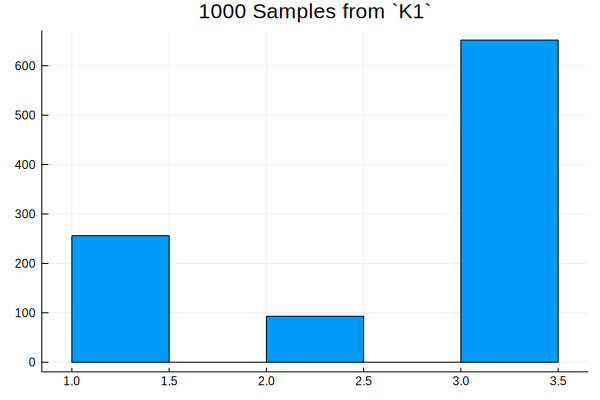

In [119]:
nsamples = 1000
Plots.histogram(simn(1, K, nsamples), label = false, title = "$nsamples Samples from `K1`")

## Graph Representation

It can be useful to represent a Markov chain as a graph rather than a matrix.
Given a Markov chain with state space $\chi$ and transition matrix $K$, there is a corresponding graph $G = (V, E)$ where $V = \chi$ and $E = \{(x, y) \in \chi \times \chi \mid K(x, y) > 0\}$.
Each edge $(x, y)$ is labelled with a weight corresponding to its transition probability $K(x, y)$.
Naturally, self-loops correspond to cases where $K(x,x) > 0$.

In [120]:
using GraphPlot, LightGraphs

g = DiGraph(K)  # Creates a directed graph from the adjacency matrix
gplot(g)

ArgumentError: ArgumentError: Package GraphPlot not found in current path:
- Run `import Pkg; Pkg.add("GraphPlot")` to install the GraphPlot package.


## Higher Order Transitions
For reasons that will become more clear, we are primarily interested in the long-term behaviour of a Markov chian.
$K$ gives us one-step transition probabilities, but what about $2, 3, 4, ..., \infty$ steps?

To compute the probability of transitioning from some $x$ to $y$ in exactly two steps we must (i) enumerate all paths through the graph that start in state $x$ and end up in state $y$ in two steps, and (ii) calculate the transition probabiliy associated with each path.
Just as we represented first-order transition probabilities as a  Matrix $k$, we can represent seecond order probabilities with a matrix, which we wil denote $K^2$, defined as:

$$
K^2(x, y) = \sum K(x, a)K(a, y)
$$

Astute readers will notice that my choice of $K^2$ to denote the second-order transition probabilities was not arbitrary.
More generally, the $n$th order transition probabilities are the $K^n$.
The long term behaviour of the Markov Chain can then be understood by seeing what happens as $n$ increases.

In [121]:
Ka = [0 1 0
      0 0 1
      1 0 0]

Kb = [0 1.0 0
      0.5 0.5 0
      0 0 1.0]

Kc = [0 1.0 0
      0.0 0.4 0.6
      0.3 0 0.7]

3×3 Array{Float64,2}:
 0.0  1.0  0.0
 0.0  0.4  0.6
 0.3  0.0  0.7

Let's visualise the heatmap

┌ Info: Saved animation to 
│   fn = /Users/francismccann/spring2020/CausalModels.jl/notebooks/tmp.gif
└ @ Plots /Users/francismccann/.julia/packages/Plots/PuQ4f/src/animation.jl:98


Plots.AnimatedGif("/Users/francismccann/spring2020/CausalModels.jl/notebooks/tmp.gif")
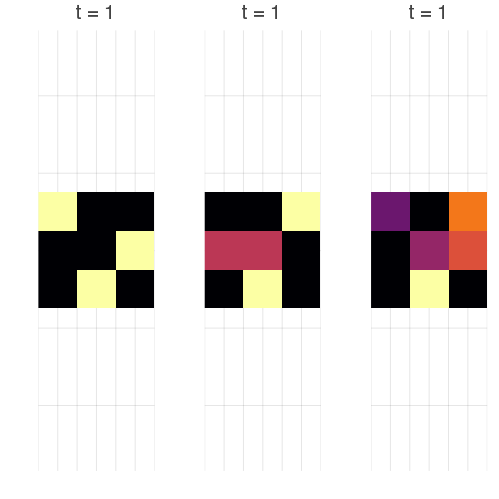

In [122]:
function plotK(K, i)
  Plots.heatmap(K^i;
                legend = false,
                xaxis = false,
                yaxis = false,
                framestyle=:box_style,
                aspect_ratio=1,
                size = (500, 500),
                title = "t = $i")
end

using Plots

anim = @animate for i=1:15
  plot(plotK(Ka, i), plotK(Kb, i), plotK(Kc, i), layout = (1, 3))
end
gif(anim; fps = 2)

## Stationary Distributions

As we have just seen
Since $\chi$ is finite, we can represent a probability distribution over it as a probability vector.
Then, if the initial state is specified by $\pi$, the distribution over states after one step in the chain is simply:

$$
\pi K
$$

The distribution $\pi$ is __stationary__ (with respect to $K$) if taking a step according to $K$ does not change the distribution over states.
That is:

$$
\pi = FINISHME
$$

Stationarity is also easy to compute:

Hint: Use ≈ (isapprox) instead of equality due to floating point imprecision

In [123]:
isstationary(π, K) = FINISHME # Hint: use ≈ for equality

isstationary (generic function with 1 method)

In the gif images above, only the third graph converges to its stationary distribution

In [9]:
"`n` such that `K^n` is stationary distribution"
function convergencepower(K)
  FINISHME
end

@testset "Stationary distribution" begin
  @test convergencepower(K) == 21
  π = [0.4220779220780727 0.1818181818182467 0.3961038961040375]
  @test isstationary(π, K^21)
end

Test Summary:           | Pass  Total
Stationary distribution |    2      2


Test.DefaultTestSet("Stationary distribution", Any[], 2, false)

## The Fundamental Theorem of Markov Chains.

The fundamental theorem of Markov chains says that a particular class (`Kc`, but not `Ka`, or `Kb` above) of Markov chains have a unique stationary distribution, and that stationary distribution is found by taking $n$ to infinity in $K^n$.
Formally:
If a Markov chain $K$ is irreducible and aperiodic it has a unique stationary distribtion $\pi$.
Moreover $K^n(x,y) \to \pi(y)$ as $t \to \infty$ for all $x, y \in \chi$:

Irreducibility means that the graph is connected.
This is easy to compute:

In [129]:
using LightGraphs

"A directed graph is irreducible if it is strongly connected"
function isirreducible(g::DiGraph) 
    return is_strongly_connected(g)
end
    # (Hint use an existing function from LightGraphs)

"A stochastic matrix is irreudicble if associated graph is irreducible"
isirreducible(K::Matrix) = isirreducible(DiGraph(K))

isirreducible

This definition is fundamental because it means that if we run a markov for a long enough time (e.g. we call `simn(x, K, n)` for some large `n`), the resulting sample will be (i) independent of what `x` is and (ii) it will be a sample from some unique distribution -- the stationary distribution.
We will see in the following section how to exploit this property to do inference.

# The Metropolis Algorithm
Understanding the stationary behaviour of Markov chains can be useful.
For instance, as mentioned earlier, Monopoly can be modelled as Markov chain.
That said, our use case is in some sense the inverse problem.

As before we have a state space $\chi$, but now the problem is that we have a target distribution $\pi$ that we want to sample from.
One might wonder what all the fuss is about; if we have a probability vector for $\pi$ can't we just sample from it?
Afterall, we did just that in the code for `sim1` above.
The difficulty arises because in many cases $\pi$ will be too large to represent as a probability vector.
The best we can do is represent it as a probability mass function $\pi : \chi \to \mathbb{R}^+$.
Moreover, we will we want to sample from cases where $\chi$ could be countably or uncoudtably infinite, or even infinite dimensional.

The Metropolis algorithm can be thought of as method to construct a transition matrix $J$ whose stationary distribution is our target distribution $\pi$.
Specifically, the Metropolis algorithm constructs $J$ from some other arbitrary transition matrix $K$.

$$
J(x, y) = K(x, y) \cdot \min\left(1, \frac{\pi(y)}{\pi(x)}\right)
$$

Algorithmically:

In [133]:
using LinearAlgebra
"`true` with probability `p`"
flip(rng, p) =  rand(Bernoulli(p))==1 ? true : false

flip(p) = flip(Random.GLOBAL_RNG)

"Take one step from `x` using Metropolis to sample from `π` using proposal `K`"
function simMetropolis1(rng, x, K, π)
    while true
        
        p=dot(K,min(1,π(y)/π(x)))
end

simMetropolis1(x, K, π) = simMetropolis1(Random.GLOBAL_RNG, x, K, π)

"Take `n` steps using Metropolis algorithm"
function simMetropolisn(rng, x, K, π, n)
  return 
end

simMetropolisn(x, K, π, n) = simMetropolisn(Random.GLOBAL_RNG, x, K, π, n)

Ksym = [0.3 0.2 0.5
        0.2 0.4 0.4
        0.5 0.4 0.1]
π1(x) = [0.3, 0.6, 0.1][x]

seed = 0
@test simMetropolis1(Random.MersenneTwister(seed), 1, Ksym, π1) == 1

Error During Test at In[133]:27
  Test threw exception
  Expression: simMetropolis1(Random.MersenneTwister(seed), 1, Ksym, π1) == 1
  UndefVarError: y not defined
  Stacktrace:
   [1] simMetropolis1(::MersenneTwister, ::Int64, ::Array{Float64,2}, ::typeof(π1)) at ./In[133]:9
   [2] top-level scope at In[133]:27
   [3] eval at ./boot.jl:330 [inlined]
   [4] softscope_include_string(::Module, ::String, ::String) at /Users/francismccann/.julia/packages/SoftGlobalScope/cSbw5/src/SoftGlobalScope.jl:218
   [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/francismccann/.julia/packages/IJulia/yLI42/src/execute_request.jl:67
   [6] #invokelatest#1 at ./essentials.jl:709 [inlined]
   [7] invokelatest at ./essentials.jl:708 [inlined]
   [8] eventloop(::ZMQ.Socket) at /Users/francismccann/.julia/packages/IJulia/yLI42/src/eventloop.jl:8
   [9] (::IJulia.var"#15#18")() at ./task.jl:333
  


Test.FallbackTestSetException: There was an error during testing

__TEST__: this histogram should look like the values on `π1`

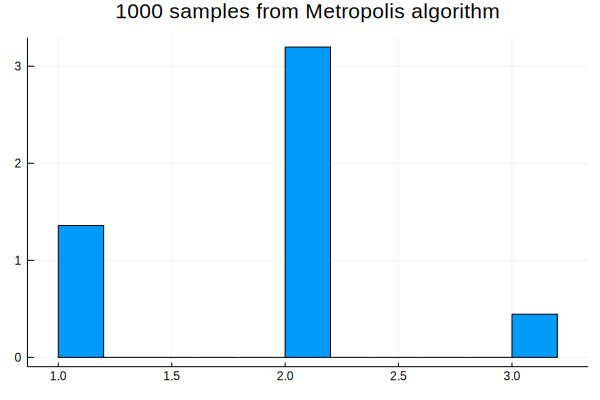

In [12]:
Plots.histogram(simMetropolisn(1, Ksym, π1, 1000); normalize = true, label = false,
                title = "$nsamples samples from Metropolis algorithm")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*